<a href="https://colab.research.google.com/github/fvillena/mlb/blob/master/4-deep-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.

**Importante**: Este notebook fue programado para sólo funcionar en Google Colab https://colab.research.google.com/

Para este notebook se utilizaron los datos de https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 y código de https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia

## Preparación

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix, classification_report

import tensorflow as tf

Using TensorFlow backend.


Google Colab nos ofrece poder utilizar GPUs (Graphical Processing Units) para realizar el entrenamiento. La utilización de este hardware nos facilita un entrenamiento muy significativamente más rápido que el entrenamiento en CPU.

In [2]:
tf.test.gpu_device_name() # Verificamos que Tensorflow está utilizando una GPU

'/device:GPU:0'

In [3]:
# Obtenemos el conjunto de datos desde el servidor de SASIBA.
!wget --no-check-certificate "http://www.sasiba.uchile.cl/index.php/s/u0YVAFP5jkDqhp2/download" -O chest_xray.zip

--2020-07-01 15:50:19--  http://www.sasiba.uchile.cl/index.php/s/u0YVAFP5jkDqhp2/download
Resolving www.sasiba.uchile.cl (www.sasiba.uchile.cl)... 200.89.79.35
Connecting to www.sasiba.uchile.cl (www.sasiba.uchile.cl)|200.89.79.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.sasiba.uchile.cl/index.php/s/u0YVAFP5jkDqhp2/download [following]
--2020-07-01 15:50:20--  https://www.sasiba.uchile.cl/index.php/s/u0YVAFP5jkDqhp2/download
Connecting to www.sasiba.uchile.cl (www.sasiba.uchile.cl)|200.89.79.35|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1225631155 (1.1G) [application/zip]
Saving to: ‘chest_xray.zip’

chest_xray.zip      100%[===================>]   1.14G  20.1MB/s    in 59s     

2020-07-01 15:51:19 (19.9 MB/s) - ‘chest_xray.zip’ saved [1225631155/1225631155]



In [4]:
# Descomprimimos el conjunto de datos.
!unzip chest_xray.zip -d chest_xray/

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
 

## Preprocesamiento

In [5]:
# Configuramos las rutas de los datos
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

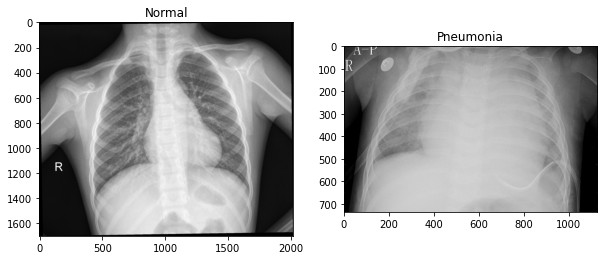

In [6]:
# Miramos un par de radiografías normales y patólogicas al azar

rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]

norm_pic_address = train_n+norm_pic

rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic

norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap="gray")
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap="gray")
a2.set_title('Pneumonia')

plt.show()

In [7]:
# Configuramos el generador de datos que utilizará nuestra red

batch_size = 32

# Queremos aumentar los datos del conjunto de prueba al generar imágenes sintéticas distorisionadas
train_datagen = ImageDataGenerator(rescale = 1./255, # A las imágenes se les normaliza el brillo
                                   shear_range = 0.2, # Distorsionamos las imágenes
                                   zoom_range = 0.2, # Acercamos las imágenes
                                   horizontal_flip = True) # Volteamos horizontalmente las imágenes

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64), # Las imágenes se redimensionan a 64*64
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 color_mode="grayscale") # Sólo utilizamos el canal de brillo

val_set = test_datagen.flow_from_directory(val_folder,
                                            target_size=(64, 64),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle = False,
                                            color_mode="grayscale")

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle = False,
                                            color_mode="grayscale")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Modelamiento

In [8]:
# Construimos la arquitectura de la red neuronal

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1))) # Capa de convolución

cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu"))

cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Creamos la arquitectura

In [9]:
# Verificamos la arquitectura

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [10]:
# Entrenamos la red neuronal

cnn_history = cnn.fit_generator(training_set,
                         epochs = 10, # Entrenamos la red por 10 épocas
                         validation_data = val_set)

Epoch 1/10
163/163 [==============================] - 50s 306ms/step - loss: 0.3820 - accuracy: 0.8309 - val_loss: 0.3701 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 49s 300ms/step - loss: 0.2427 - accuracy: 0.8974 - val_loss: 0.8534 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 49s 301ms/step - loss: 0.2240 - accuracy: 0.9118 - val_loss: 0.4444 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 49s 302ms/step - loss: 0.1940 - accuracy: 0.9247 - val_loss: 0.4342 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 49s 301ms/step - loss: 0.1890 - accuracy: 0.9247 - val_loss: 0.5881 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 49s 301ms/step - loss: 0.1746 - accuracy: 0.9327 - val_loss: 0.7356 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 49s 303ms/step - loss: 0.1631 - accuracy: 0.9352 - val_loss: 0.5734 - val_ac

In [11]:
predictions = cnn.predict(test_set, verbose = 1) > 0.5 # Predecimos sobre el conjunto de prueba

20/20 [==============================] - 5s 226ms/step


In [12]:
confusion_matrix(test_set.classes, predictions) # Matriz de confusión

array([[177,  57],
       [  5, 385]])

In [13]:
print(classification_report(test_set.classes, predictions)) # Resumen del rendimiento del modelo

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       234
           1       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



### Actividad 1

**Modifica la arquitectura agregando una nueva capa de convolución y max-pooling prueba si mejoran las métricas**


In [14]:
cnn.save("cnn.h5")

## Exploración

Para entender cómo funciona la red neuronal, visualizaremos las salidas de cada una de las capas.

In [15]:
def image_loader(path):
  image_location = path # Seleccionamos una imagen del conjunto de prueba
  img =Image.open(image_location)
  # Cargamos la imagen
  img_resized = tf.keras.preprocessing.image.load_img(
      image_location,
      target_size = (64, 64), # Debemos redimensionar la imagen para poder ser ingresada a la red
      color_mode="grayscale"
  )
  # Transformamos la imagen en un arreglo de las dimensiones que recibe la red
  img_array = tf.keras.preprocessing.image.img_to_array(
      img_resized
  )
  img_array = np.expand_dims(
      img_array,
      axis=0
  )
  return img, img_resized, img_array

In [16]:
def get_activations(model,img_array):
  # Creamos un modelo que entrega los resultados después de cada capa
  layer_outputs = [layer.output for layer in model.layers]
  layer_names = [layer.name for layer in model.layers]
  activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
  activations = activation_model.predict(img_array)
  activations = list(zip(layer_names,activations))
  return activations

In [17]:
# Esta función grafica los resultados de los filtros de la capa de convolución
def plot_conv_layer_result(activations,j):
  fig, axs = plt.subplots(
      nrows=4,
      ncols=8,
      figsize=(15,8)
  )
  fig.suptitle(activations[j][0])
  for i,ax in enumerate(axs.ravel()):
      ax.imshow(activations[j][1][0,:,:,i], cmap="viridis")
      ax.axis("off")
  plt.show()

In [18]:
# Con esto graficamos los arreglos unidimensionales
def plot_1d_layer_result(activations,j):
  values = activations[j][1][0,:]
  plt.bar(
      range(len(values)),
      values
  )
  plt.title(activations[j][0])
  plt.show()

### Radiografía de Pneumonia

In [19]:
pneumonia_img, pneumonia_img_resized, pneumonia_img_array = image_loader("chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")

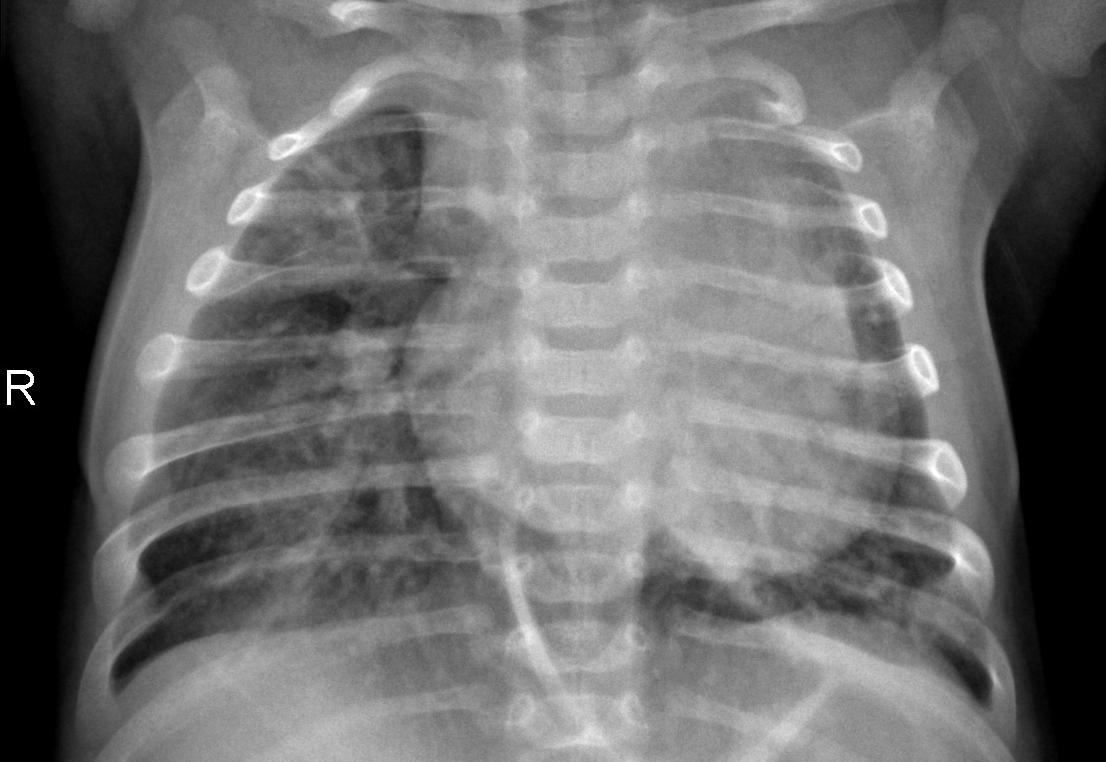

In [20]:
pneumonia_img # Asi se ve la imagen original

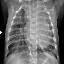

In [21]:
pneumonia_img_resized # Esta es la imagen con las dimensiones correctas para ingresarla a la red

In [22]:
pneumonia_img_array.shape # Esta es la dimensión del arreglo numérico que se ingresará a la red

(1, 64, 64, 1)

In [23]:
# Predecimos sobre el arreglo
cnn.predict(pneumonia_img_array)

array([[1.]], dtype=float32)

In [24]:
pneumonia_activations = get_activations(cnn,pneumonia_img_array)

En el siguiente gráfico vemos las 32 imágenes correspondientes a la salida de cada uno de los filtros de la capa de convolución.

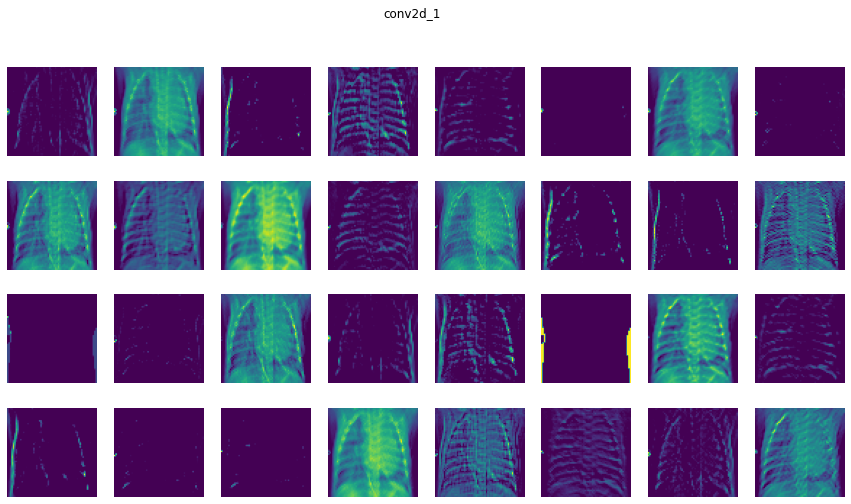

In [25]:
plot_conv_layer_result(pneumonia_activations,0)

En el siguiente gráfico observamos como la capa de max-pooling reduce la resolución de la imagen.

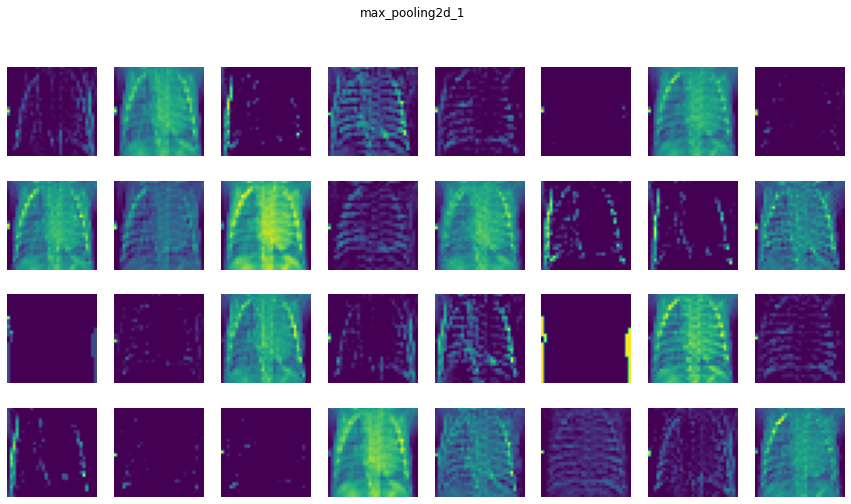

In [26]:
plot_conv_layer_result(pneumonia_activations,1)

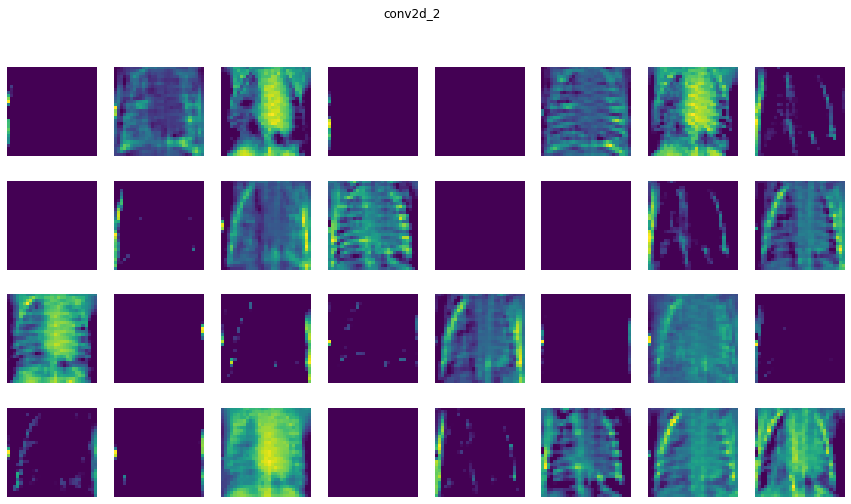

In [27]:
plot_conv_layer_result(pneumonia_activations,2)

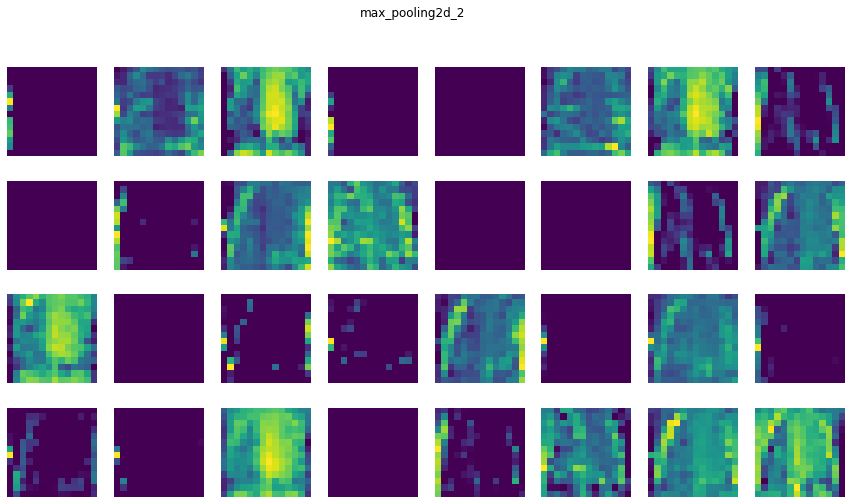

In [28]:
plot_conv_layer_result(pneumonia_activations,3)

Después del segundo max-pooling tenemos sólo arreglos unidimensionales, este primer resultado son todos los elementos del resultado anterior concatenados en un sólo arreglo.

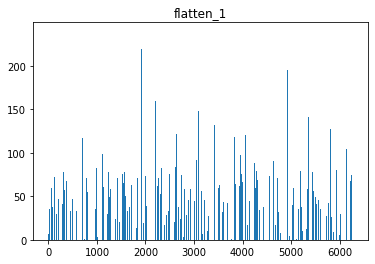

In [29]:
plot_1d_layer_result(pneumonia_activations,4)

Con la capa densa reducimos el número de elementos del arreglo anterior.

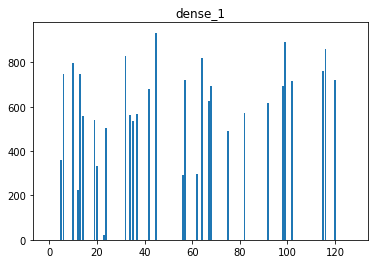

In [30]:
plot_1d_layer_result(pneumonia_activations,5)

La última capa tiene sólo 1 neurona correspondiente a la clasificación final de la red

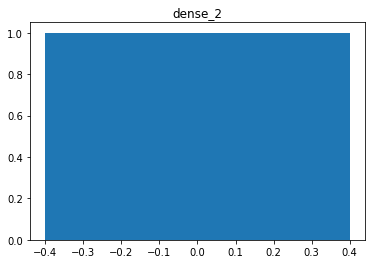

In [31]:
plot_1d_layer_result(pneumonia_activations,6)

### Radiografía Normal

In [32]:
normal_img, normal_img_resized, normal_img_array = image_loader("chest_xray/test/NORMAL/IM-0001-0001.jpeg")

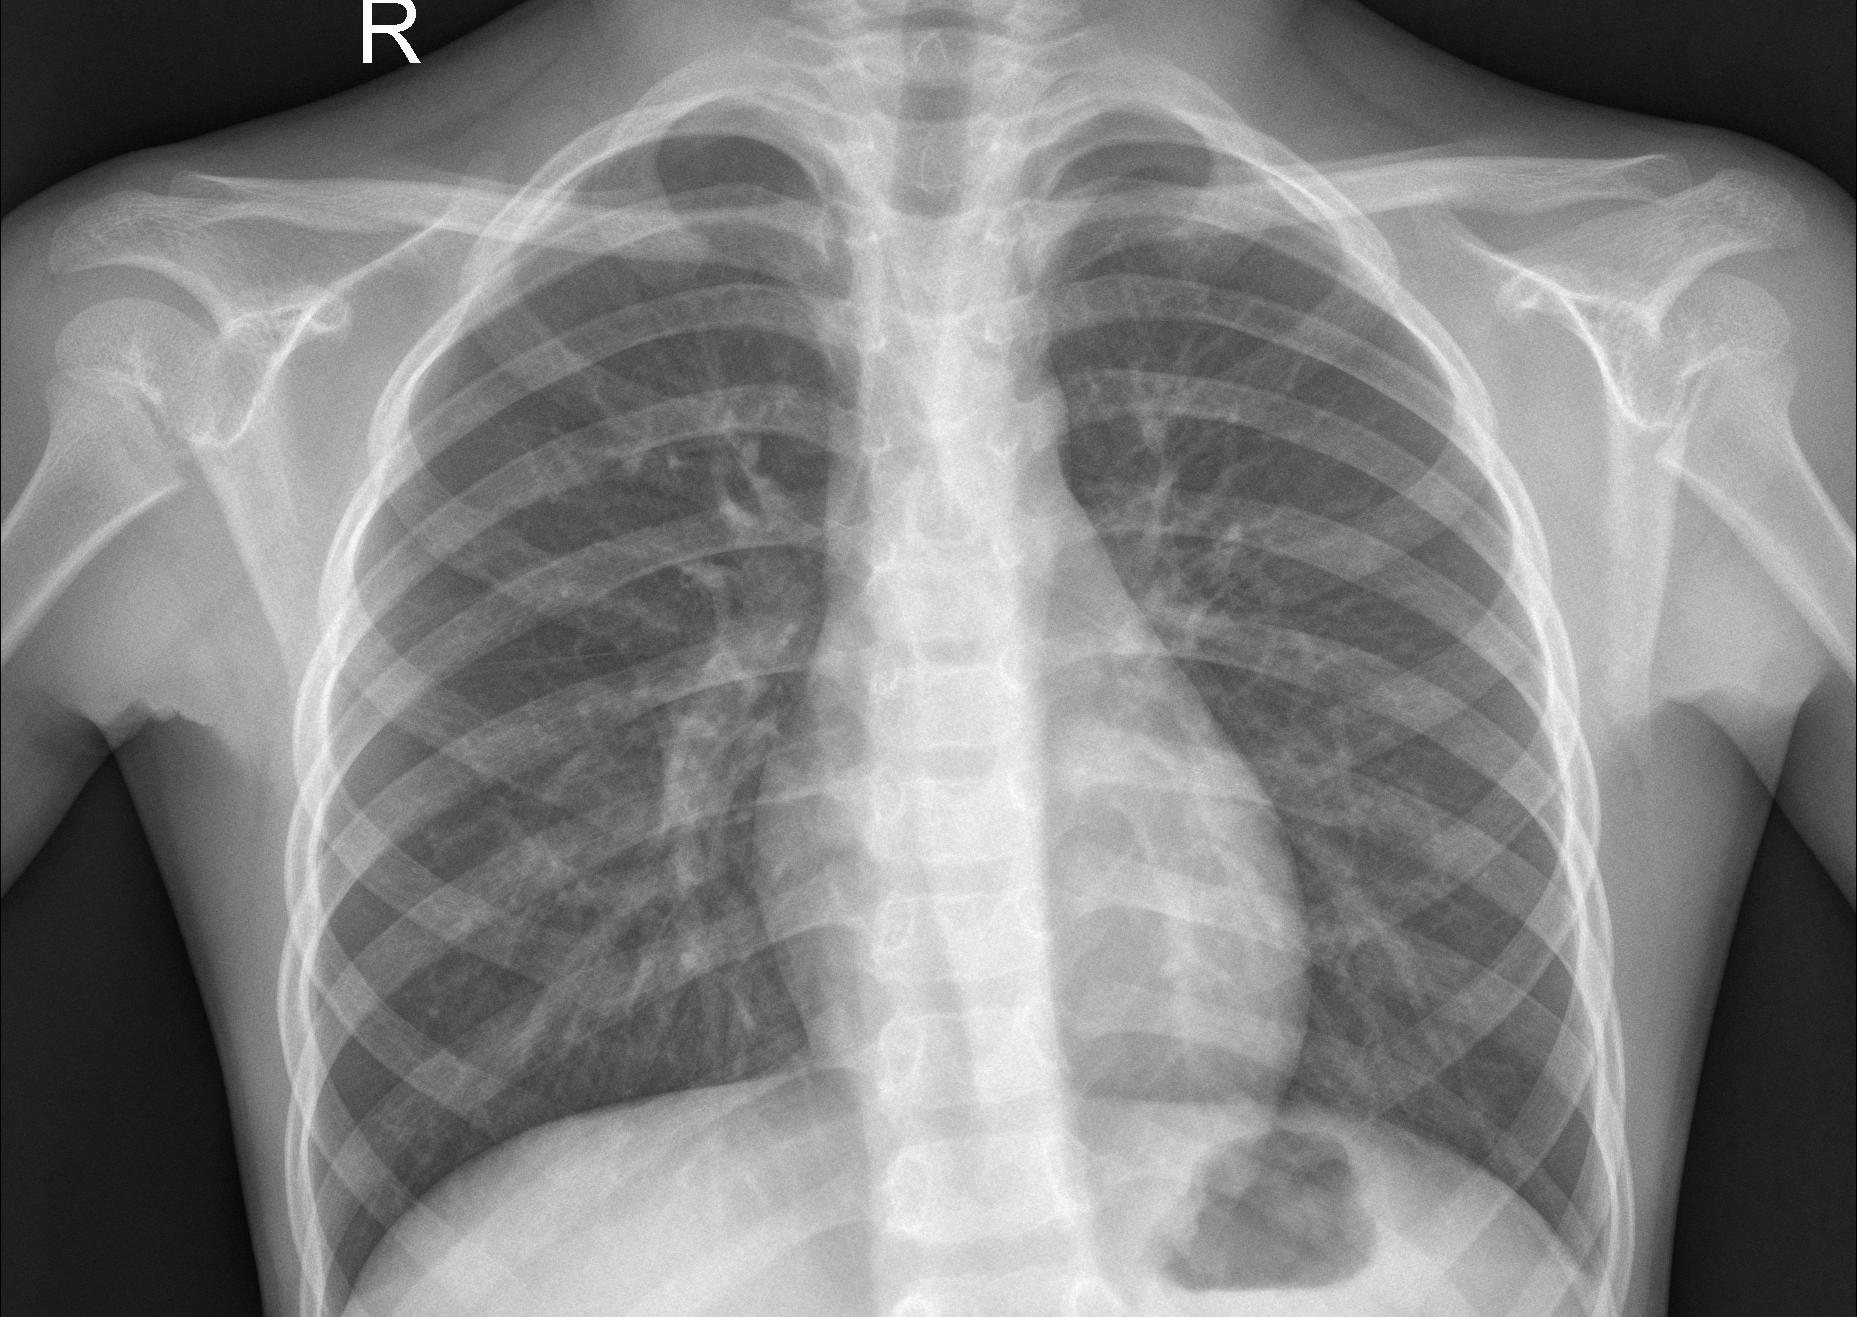

In [33]:
normal_img

In [34]:
cnn.predict(normal_img_array)

array([[0.]], dtype=float32)

In [35]:
normal_activations = get_activations(cnn,normal_img_array)

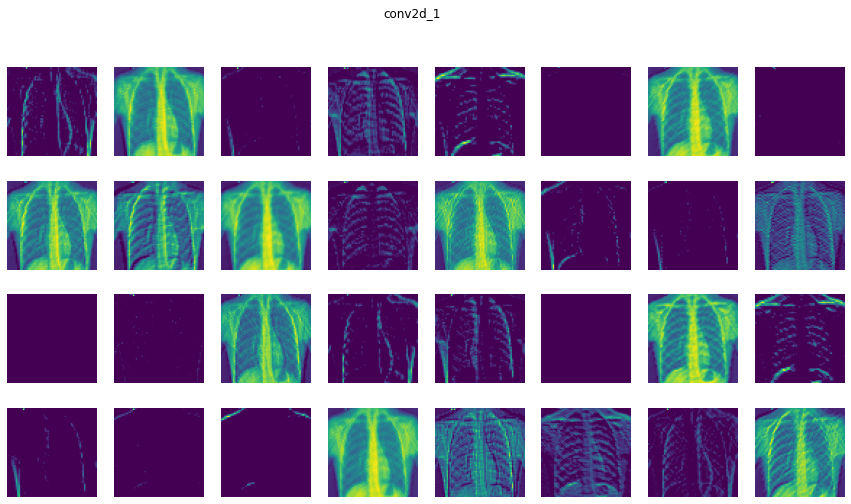

In [36]:
plot_conv_layer_result(normal_activations,0)

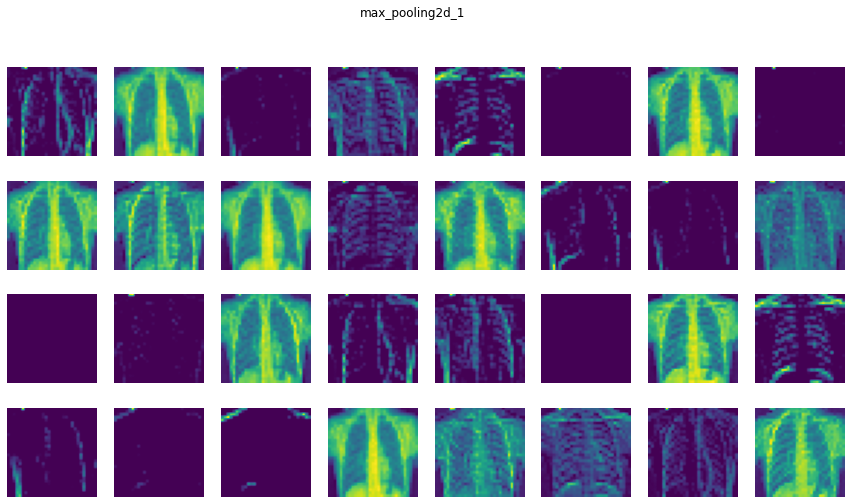

In [37]:
plot_conv_layer_result(normal_activations,1)

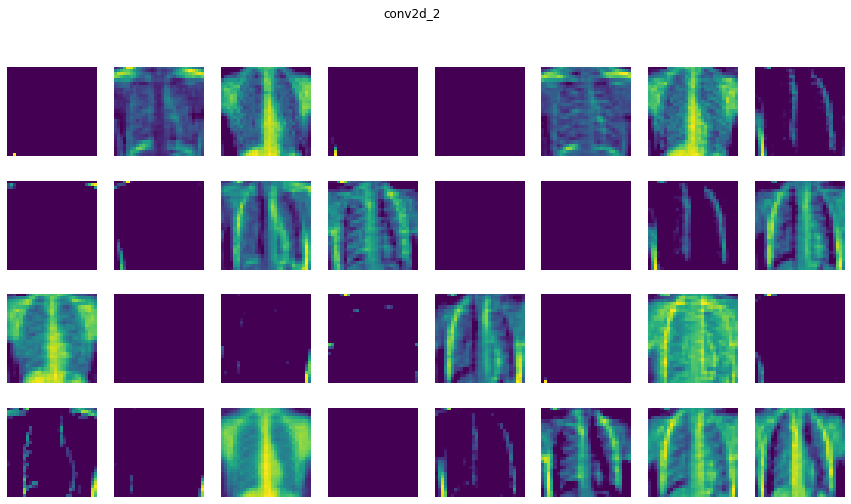

In [38]:
plot_conv_layer_result(normal_activations,2)

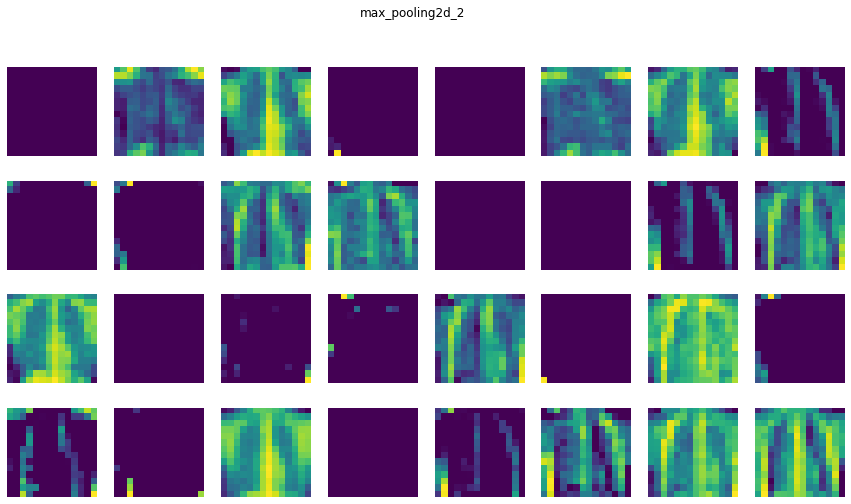

In [39]:
plot_conv_layer_result(normal_activations,3)

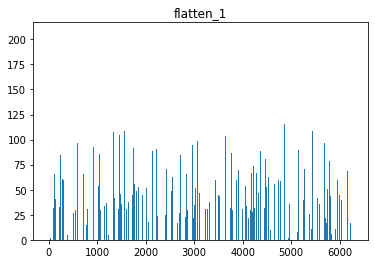

In [40]:
plot_1d_layer_result(normal_activations,4)

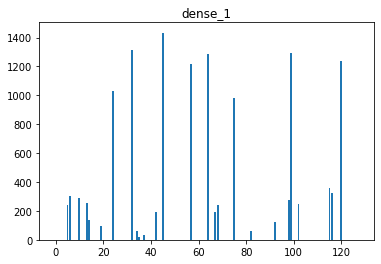

In [41]:
plot_1d_layer_result(normal_activations,5)

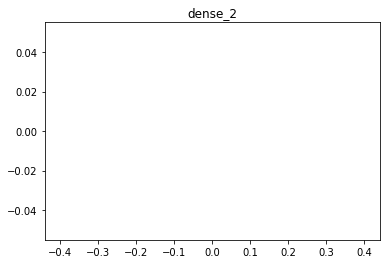

In [42]:
plot_1d_layer_result(normal_activations,6)